# tasc-poster
notebook for making plots for my tasc/kasc poster\
aim to make:
- Violin plots of overall prediction uncertainty
- Density of points in grid
- Emulation uncertainty over grid
- Posterior samples of hare with draws of noise
- Posterior samples for similar star compared to published values

In [1]:
# stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy.spatial.distance import cdist
import os

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner
from cmcrameri import cm

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})

# script imports
from scripts.pitchfuncs_ultra_pca import emulator
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_nice
from scripts import prior_funcs, utils

2024-07-10 13:44:04.070467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 13:44:04.070500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 13:44:04.071523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 13:44:04.076879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 13:44:04.606416: W tensorflow/compiler/tf2

## Import grid

In [2]:
df_full = pd.concat(
    [
        pd.read_hdf(
            "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5",
            key=f"m{0.8 + i*0.02:.2f}",
        )
        for i in range(21)
    ],
    ignore_index=True,
)
df = df_full[df_full["log_g"] >= 3.6]
df = df[df["star_age"] <= 14]
df = df[df["frac_age"] >= 0.015]

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = ["radius", "luminosity", "star_feh"] + [f"nu_0_{i}" for i in range(6, 41)] + ['nu_max']

df = df.loc[(df[[f"nu_0_{i}" for i in range(6, 41)]] != 0).all(axis=1)]

cols = inputs + outputs

df = df[cols]

df.dropna(inplace=True)

df["calc_effective_T"] = utils.calc_Teff(df["luminosity"], df["radius"])
df.describe()

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,nu_max,calc_effective_T
count,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,...,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06
mean,1.021885e+00,1.440698e-02,2.814693e-01,2.117984e+00,5.000177e+00,1.312728e+00,2.116482e+00,-1.127145e-01,7.726572e+02,8.860424e+02,...,3.696535e+03,3.802234e+03,3.907317e+03,4.011806e+03,4.115788e+03,4.219425e+03,4.322952e+03,4.426627e+03,2.370506e+03,5.866797e+03
std,1.175610e-01,9.677123e-03,2.805593e-02,2.879175e-01,3.405371e+00,4.813547e-01,1.572419e+00,3.499532e-01,2.959808e+02,3.426600e+02,...,1.451591e+03,1.494205e+03,1.536228e+03,1.577500e+03,1.617908e+03,1.657417e+03,1.696104e+03,1.734156e+03,1.156533e+03,5.670330e+02
min,8.000000e-01,3.869061e-03,2.400000e-01,1.700000e+00,2.966411e-02,6.990236e-01,1.321735e-01,-1.077903e+00,2.103102e+02,2.385545e+02,...,1.002125e+03,1.032723e+03,1.063221e+03,1.093511e+03,1.123625e+03,1.153506e+03,1.183191e+03,1.212653e+03,4.317504e+02,4.096930e+03
25%,9.200000e-01,6.471429e-03,2.600000e-01,1.900000e+00,2.309880e+00,9.719693e-01,9.371542e-01,-4.000000e-01,5.476978e+02,6.234189e+02,...,2.578850e+03,2.649156e+03,2.720741e+03,2.793748e+03,2.868279e+03,2.944027e+03,3.020312e+03,3.097018e+03,1.444480e+03,5.491841e+03
50%,1.040000e+00,1.077191e-02,2.800000e-01,2.100000e+00,4.275231e+00,1.160016e+00,1.698469e+00,-1.000000e-01,7.832912e+02,8.972267e+02,...,3.760636e+03,3.866328e+03,3.970106e+03,4.072429e+03,4.174203e+03,4.276548e+03,4.380549e+03,4.486487e+03,2.352665e+03,5.859776e+03
75%,1.120000e+00,2.007835e-02,3.000000e-01,2.300000e+00,7.159688e+00,1.498369e+00,2.883064e+00,1.837200e-01,9.935144e+02,1.142381e+03,...,4.784137e+03,4.922458e+03,5.059497e+03,5.194580e+03,5.327444e+03,5.458355e+03,5.587658e+03,5.716681e+03,3.185873e+03,6.219454e+03
max,1.200000e+00,3.897971e-02,3.200000e-01,2.500000e+00,1.399997e+01,2.873431e+00,1.163902e+01,5.094573e-01,1.480807e+03,1.705344e+03,...,7.145063e+03,7.354126e+03,7.562945e+03,7.771521e+03,7.979340e+03,8.185512e+03,8.382538e+03,8.584072e+03,5.856447e+03,7.993034e+03


In [3]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" + pitchfork_name + ".pkl", "rb") as fp:
    pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info["parameter_ranges"]

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


2024-07-10 13:44:15.608474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18158 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2024-07-10 13:44:15.609019: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18447 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


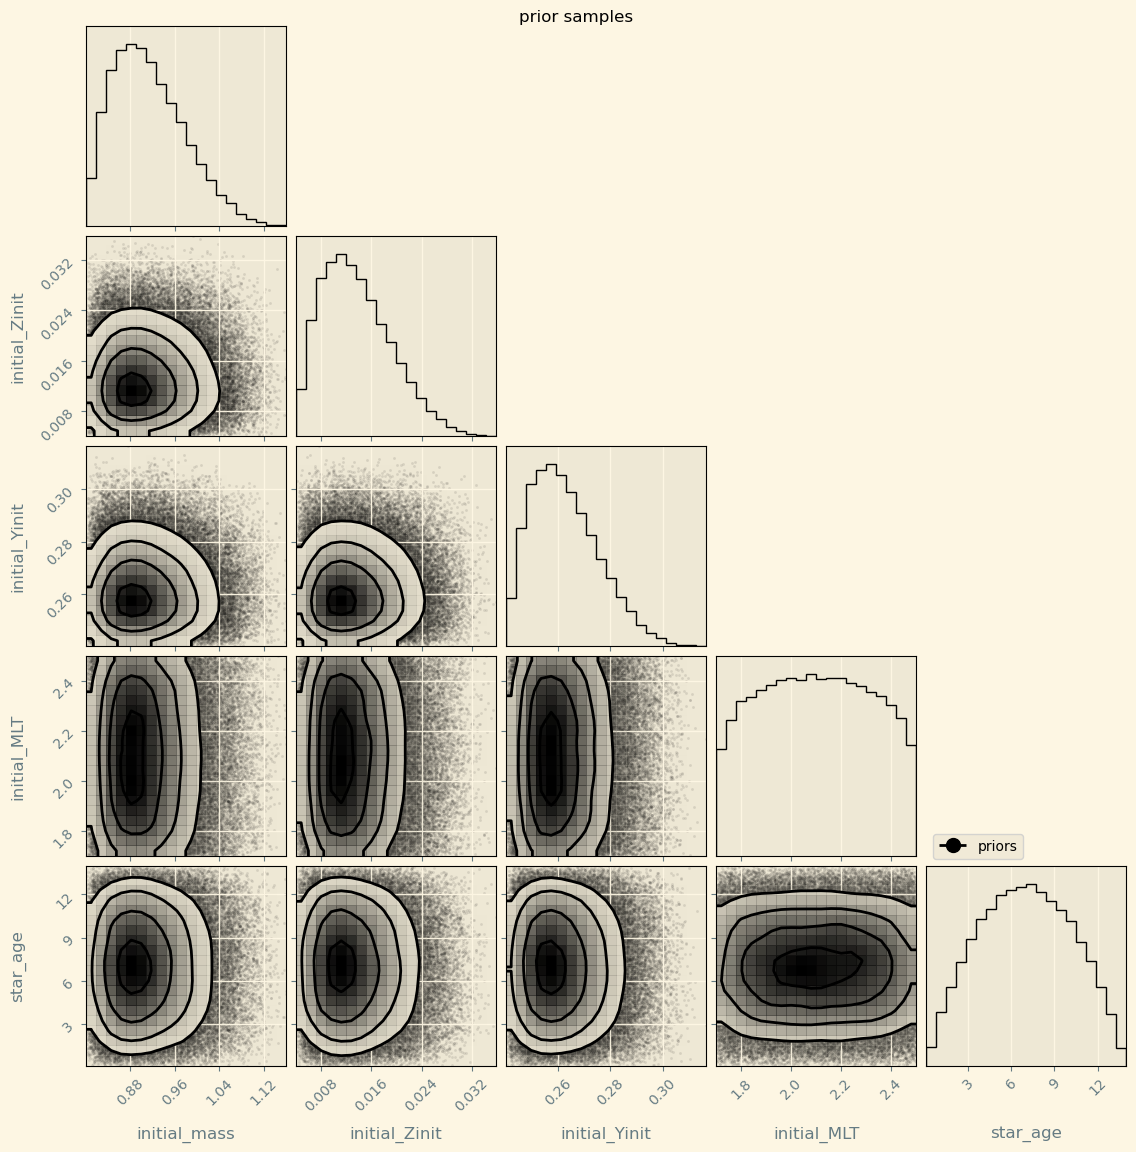

In [4]:
labels = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=2, b=2)


priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior]

size = 100000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = "black"
corner.corner(
    plot_prior_samples.T,
    labels=labels,
    color=corner_color,
    hist_kwargs={"density": True},
    smooth=True,
)
legend_labels = legend_labels + [
    Line2D(
        [0],
        [0],
        marker="o",
        color=corner_color,
        markerfacecolor=corner_color,
        markersize=10,
        label="priors",
    )
]
plt.suptitle("prior samples")
plt.legend(handles=legend_labels, bbox_to_anchor=(0.0, 1.0, 1.0, 0.0), loc=0)
plt.show()

In [5]:
def closest_grid_point(point, grid_df, columns=['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']):
    return grid_df.iloc[[cdist([point], grid_df[columns].values).argmin()]]

def nu_max_n(hare_sample):
    nu_max = hare_sample['nu_max']
    nu_max_header = np.abs(hare_sample[[f'nu_0_{i}' for i in range(6,41)]]-nu_max.values[0]).min().idxmin()
    hare_sample = hare_sample.drop('nu_max', axis=1).copy()
    hare_sample.loc[:,'nu_max_n'] = nu_max_header.replace('nu_0_', '')
    return hare_sample

real_star = [1, 0.0134, 0.2485, 1.8, 4.6]
closest_hare = closest_grid_point(real_star, df)

closest_hare = nu_max_n(closest_hare)

hare_name = 'solar'
path = f'tasc_form/hare_{hare_name}'
if not os.path.exists(path):
  os.mkdir(path)
  print(f"{path} created!")
else:
  print(f"{path} already exists", end='\r')
closest_hare.to_json(path+f'/hare_{hare_name}.json')

In [26]:
def nu_max_range(nu_max_n, mode_min=14, mode_max=20):
    modes = np.random.randint(mode_min, mode_max)
    flip = np.random.randint(2)
    int_half = int(modes*0.5)
    if flip:
        n_min=nu_max_n-int_half
        n_max=nu_max_n+(modes - int_half)
    else: 
        n_min=nu_max_n-(modes - int_half)
        n_max=nu_max_n+int_half

    return n_min, n_max

def obs_noise(true, unc, skew, seed=None):
    seeded_random_state = np.random.RandomState(seed=seed)
    rvs_random_states = seeded_random_state.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = skew + scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=rvs_random_states[idx])
        idx+=1

    return noisy_obs

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex

obs_idx = 9
hare_df = pd.read_json(f'tasc_form/hare_{hare_name}/hare_{hare_name}.json')

nu_max_n = hare_df['nu_max_n'].values[0]
n_min, n_max = nu_max_range(nu_max_n)
outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min, n_max+1)]

hare_cut = hare_df[inputs+outputs]

obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[abs(i-nu_max_n)*0.025 for i in range(n_min,n_max+1)])

obs_unc_skew = np.random.uniform(-0.2,0.2) #\muHz

hare_obs = obs_noise(hare_cut[outputs].values[0],obs_unc, obs_unc_skew)

hare_obs_df = hare_cut.copy()
hare_obs_df[outputs] = hare_obs



# fig, ax = plt.subplots()

# ax.scatter(np.arange(0, len(obs_unc)),(hare_obs-hare_cut[outputs].values[0])/obs_unc)
# ax.axhline(0, c='black')
# ax.axhline(-1, c='black', linestyle='--')
# ax.axhline(1, c='black', linestyle='--')

# yabs_max = abs(max(ax.get_ylim(), key=abs))
# ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
# ax.set_xticks(np.arange(0, len(obs_unc)))
# ax.set_xticklabels(outputs)
# #ax.tick_params(axis='x', labelrotation=90)

# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# ax.set_title('z-score of observed vs true hare params')
# ax.set_ylabel('z-score')

path = f'tasc_form/hare_{hare_name}/obs{obs_idx}'
if not os.path.exists(path):
  os.mkdir(path)
  print(f"{path} created!")
else:
  print(f"{path} already exists", end='\r')
hare_obs_df.to_json(path+f'/obs{obs_idx}.json')
pd.DataFrame([obs_unc], columns=outputs).to_json(path+'/uncs.json')
# plt.savefig(path+'/zscore_plot.png', bbox_inches='tight')
# plt.close()

In [27]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

ndraw_min=2**12
ndraw_max=2**16

for obs_idx in range(5,10):
    path = f'tasc_form/hare_{hare_name}/obs{obs_idx}/'
    hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
    hare_uncs = pd.read_json(path+'uncs.json')
    hare_uncs_array = hare_uncs.values[0]

    n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
    n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))

    sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
    sigma_nn_mask[:3] = True
    sigma_nn_mask[n_min-3:n_max-2] = True

    sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

    sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))

    sigma = sigma_nn_cropped + sigma_obs

    sigma_inv = np.linalg.inv(sigma)

    _, log_sigma_det = np.linalg.slogdet(sigma)
    
    outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
    
    sampler = ultra_ns_vector_nice(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
    results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=500, frac_remain=.2)
    with open(path+'/samples.pkl', 'wb') as fp:
        pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

    sampler.cleanup()
    del results

[ultranest] Sampling 500 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1811: UserWarning: Sampling from region seems inefficient (0/4096 accepted in iteration 25). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=2  2 [0.8540..0.8553]*| it/evals=7948/1251384 eff=0.5988% N=500  0  
[ultranest] Likelihood function evaluations: 1251384
[ultranest]   logZ = -13.17 +- 0.1045
[ultranest] Effective samples strategy satisfied (ESS = 2405.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.18 total:0.21 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 500 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1811: UserWarning: Sampling from region seems inefficient (0/4096 accepted in iteration 25). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=2  3 [0.7477..0.7479]*| it/evals=7850/1588500 eff=0.2302% N=500 0   
[ultranest] Likelihood function evaluations: 1588500
[ultranest]   logZ = -13.01 +- 0.1138
[ultranest] Effective samples strategy satisfied (ESS = 2301.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.18 total:0.21 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 500 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1811: UserWarning: Sampling from region seems inefficient (0/4096 accepted in iteration 25). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-3  57 [-3.5291..-3.5286]*| it/evals=8235/1280670 eff=1.2745% N=500  
[ultranest] Likelihood function evaluations: 1280670
[ultranest]   logZ = -18.01 +- 0.1147
[ultranest] Effective samples strategy satisfied (ESS = 2434.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.22, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.18 total:0.22 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 500 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1811: UserWarning: Sampling from region seems inefficient (0/4096 accepted in iteration 25). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-12.8729..-12.8719]*| it/evals=8546/973296 eff=2.1772% N=500  
[ultranest] Likelihood function evaluations: 973296
[ultranest]   logZ = -27.99 +- 0.09912
[ultranest] Effective samples strategy satisfied (ESS = 2615.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.18 total:0.21 required:<0.50
[ultranest] done iterating.
[ultranest] Sampling 500 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1811: UserWarning: Sampling from region seems inefficient (1/4096 accepted in iteration 25). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=1  7 [0.0786..0.0788]*| it/evals=8252/874074 eff=1.4604% N=500 00   
[ultranest] Likelihood function evaluations: 874074
[ultranest]   logZ = -14.5 +- 0.1019
[ultranest] Effective samples strategy satisfied (ESS = 2433.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.10 tail:0.18 total:0.21 required:<0.50
[ultranest] done iterating.
CPU times: user 1h 6min 8s, sys: 29.6 s, total: 1h 6min 38s
Wall time: 1h 5min 41s


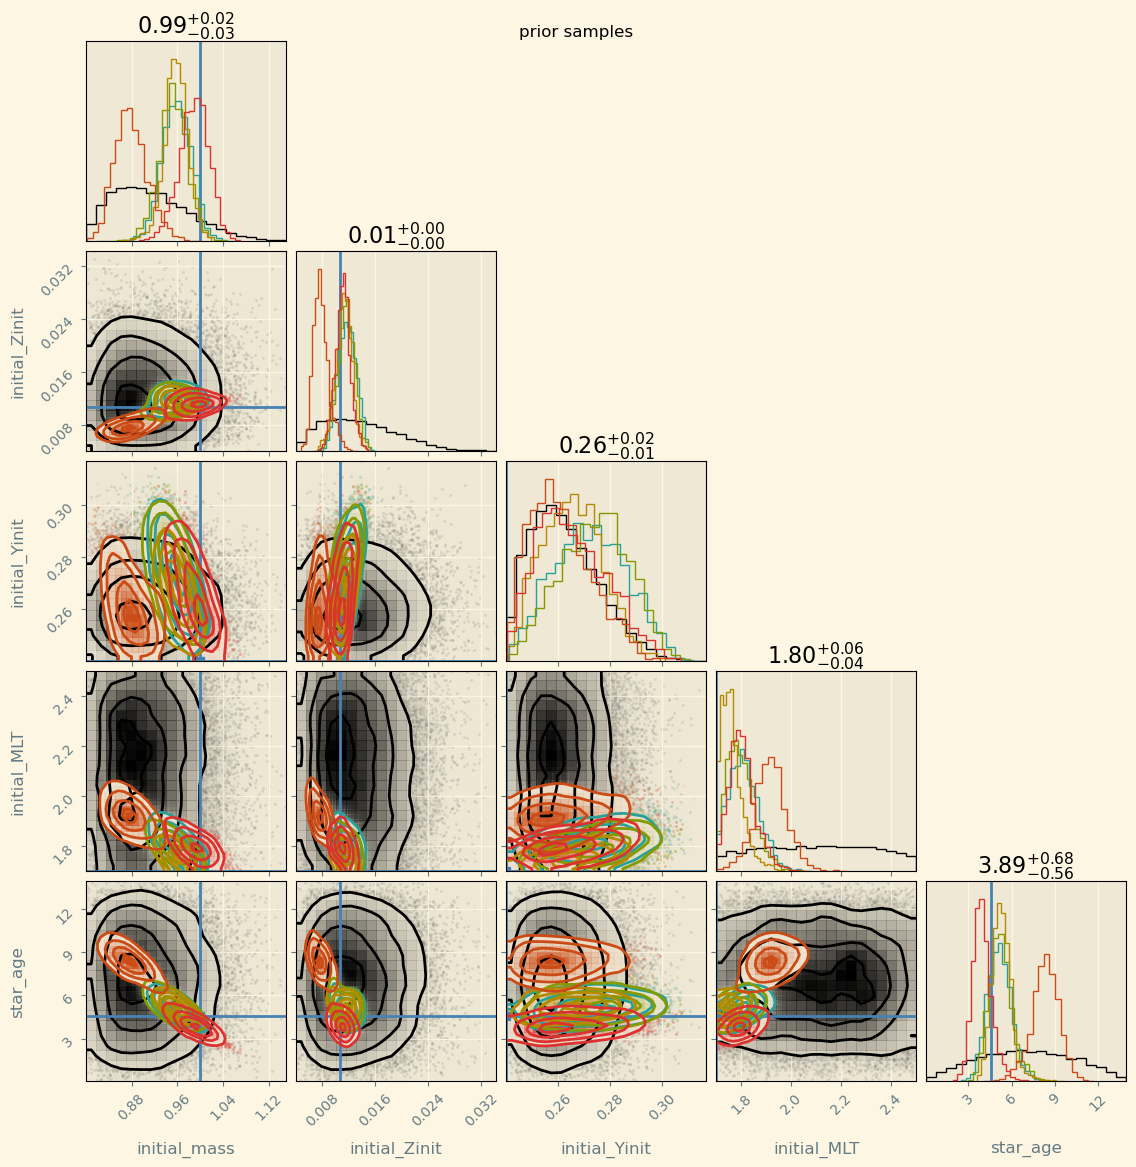

In [28]:
def inspect_hare(hare_name):
    path = f'tasc_form/hare_{hare_name}/'

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
    
    mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=2, b=2)
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior]

    hare_df = pd.read_json(path+f'hare_{hare_name}.json')[labels]
        
    colours = [colour["color"] for colour in plt.rcParams["axes.prop_cycle"]]

    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, truths = hare_df.values[0], color=corner_color, hist_kwargs={'density':True}, smooth=True);
    for obs_idx in range(5):
        with open(path+f'/obs{obs_idx}/samples.pkl', 'rb') as fp:
         samples = pickle.load(fp)
            
        corner.corner(samples['samples'], fig=figure, color=colours[obs_idx+1],hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle('prior samples')
    plt.show()

    
inspect_hare('solar')

## Perky

In [5]:
perky_df = pd.DataFrame([{
    'calc_effective_T' : 6037,
    'luminosity' : 1.814,
    'star_feh' : -0.04,
    'nu_0_13' : 1497.40,
    'nu_0_14' : 1601.54,
    'nu_0_15' : 1705.15,
    'nu_0_16' : 1807.19,
    'nu_0_17' : 1909.96,
    'nu_0_18' : 2012.98,
    'nu_0_19' : 2117.29,
    'nu_0_20' : 2221.51,
    'nu_0_21' : 2325.54,
    'nu_0_22' : 2429.95,
    'nu_0_23' : 2533.85,
    'nu_0_24' : 2639.20,
    'nu_0_25' : 2743.84,
    'nu_0_26' : 2850.07,
    'nu_0_27' : 2955.03
}])

perky_uncs = pd.DataFrame([{
    'calc_effective_T' : 77,
    'luminosity' : 1e9,
    'star_feh' : 0.1,
    'nu_0_13' : 0.27,
    'nu_0_14' : 0.19,
    'nu_0_15' : 0.12,
    'nu_0_16' : 0.12,
    'nu_0_17' : 0.1,
    'nu_0_18' : 0.1,
    'nu_0_19' : 0.08,
    'nu_0_20' : 0.06,
    'nu_0_21' : 0.09,
    'nu_0_22' : 0.11,
    'nu_0_23' : 0.16,
    'nu_0_24' : 0.22,
    'nu_0_25' : 0.47,
    'nu_0_26' : 0.70,
    'nu_0_27' : 0.68
}])


In [ ]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

ndraw_min=2**10
ndraw_max=2**16

hare_observed = perky_df
hare_uncs = perky_uncs
hare_uncs_array = hare_uncs.values[0]

n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))

sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
sigma_nn_mask[:3] = True
sigma_nn_mask[n_min-3:n_max-2] = True

sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))

sigma = sigma_nn_cropped + sigma_obs

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]

sampler = ultra_ns_vector_nice(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=1000, frac_remain=.1)

path = f'tasc_form/hare_perky'
with open(path+'/samples.pkl', 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

sampler.cleanup()
del results

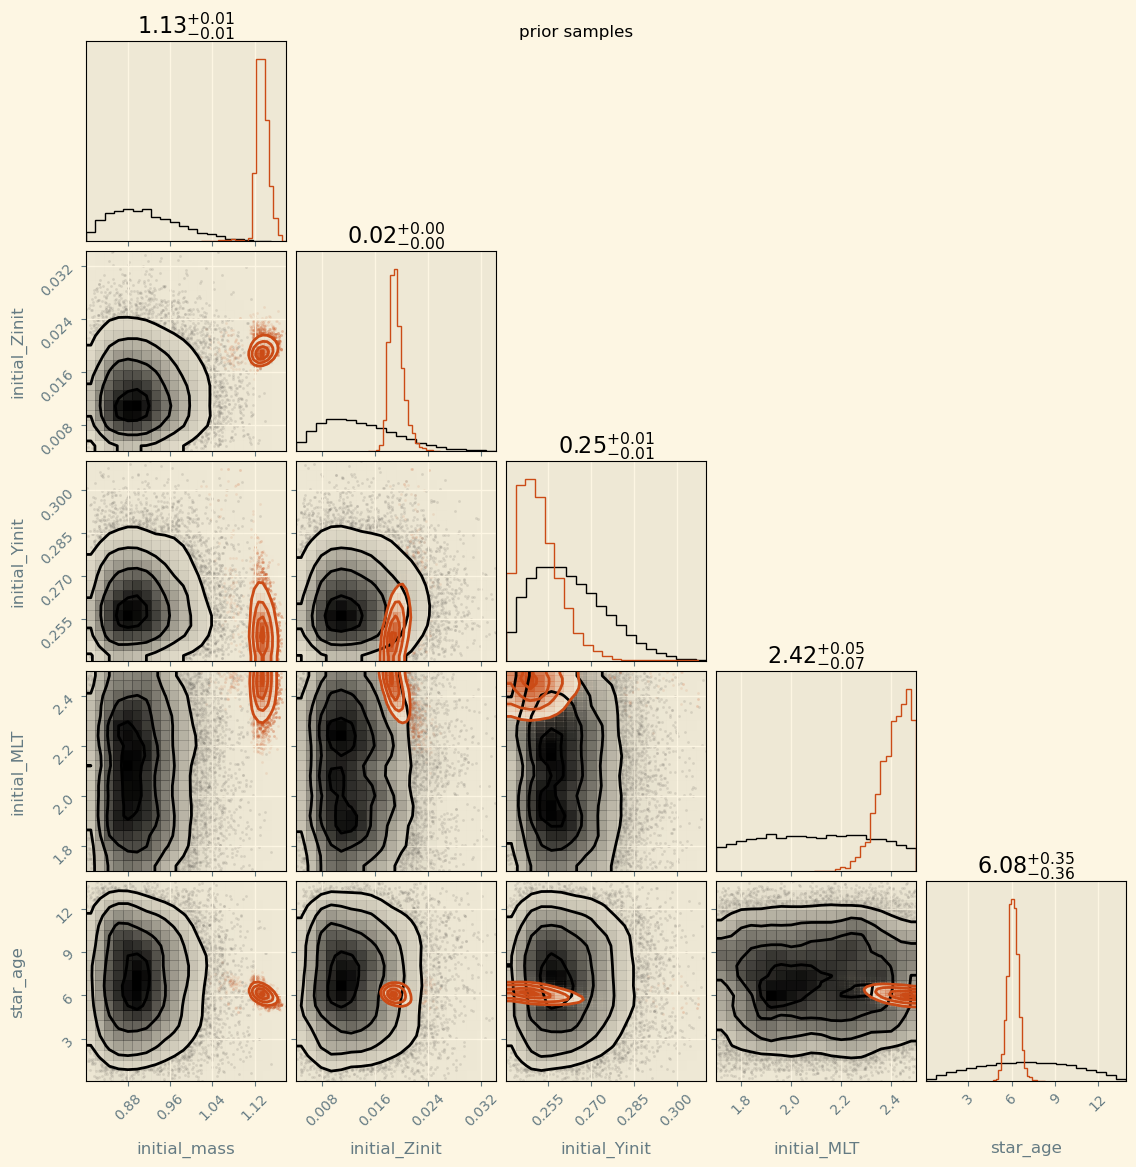

In [9]:
def inspect_hare(hare_name):
    path = f'tasc_form/hare_{hare_name}'

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
    
    mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=2, b=2)
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior]
    
    colours = [colour["color"] for colour in plt.rcParams["axes.prop_cycle"]]

    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
    with open(path+f'/samples.pkl', 'rb') as fp:
     samples = pickle.load(fp)
        
    corner.corner(samples['samples'], fig=figure, color=colours[4],hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.show()

    
inspect_hare('perky')

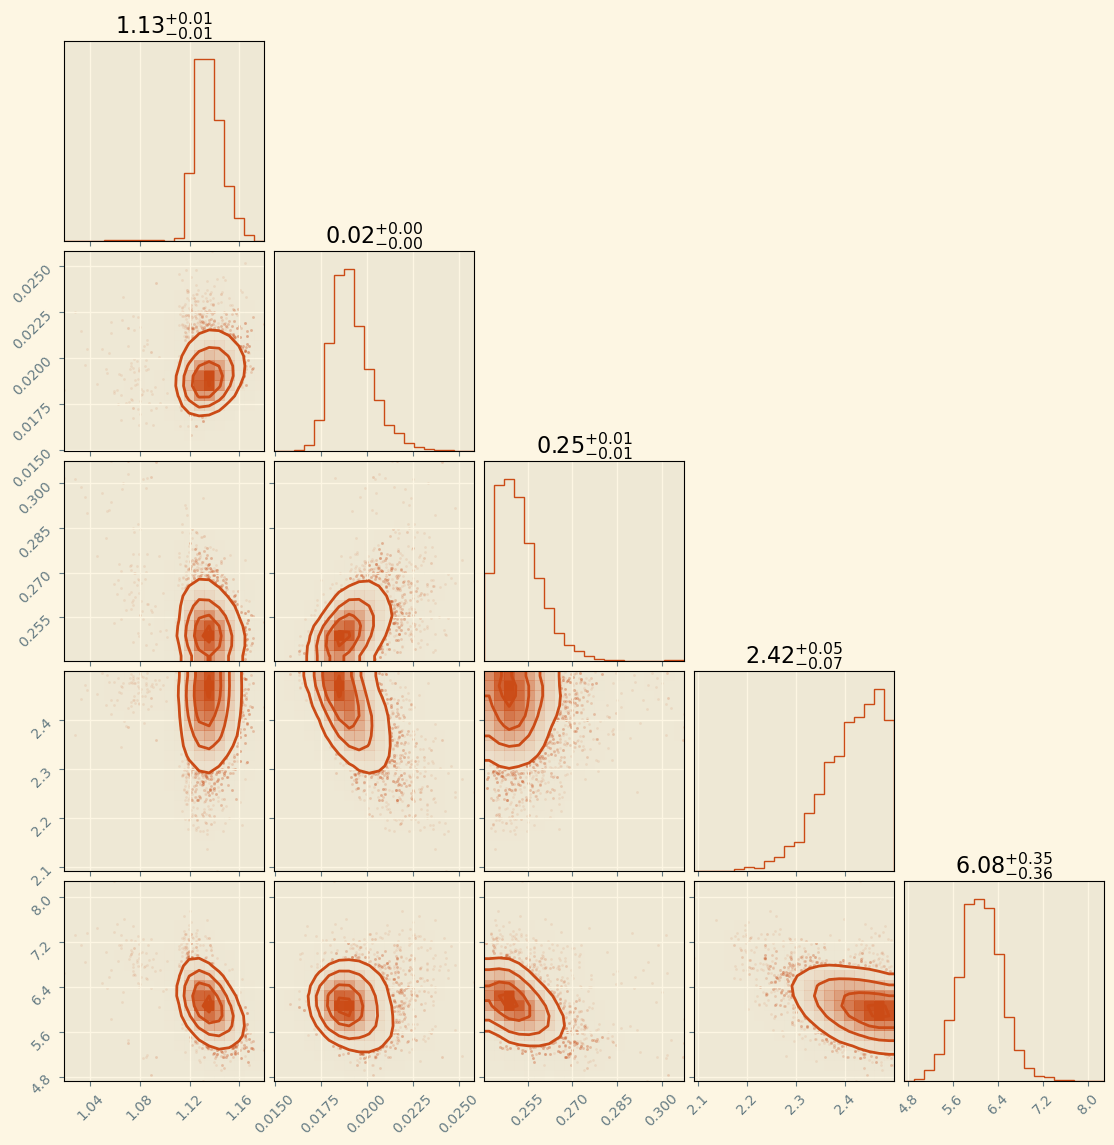

In [6]:
def inspect_hare(hare_name):
    path = f'tasc_form/hare_{hare_name}'

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
    
    colours = [colour["color"] for colour in plt.rcParams["axes.prop_cycle"]]

    with open(path+f'/samples.pkl', 'rb') as fp:
     samples = pickle.load(fp)
        
    figure = corner.corner(samples['samples'], color=colours[4],hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.show()

    
inspect_hare('perky')